# Amplitudes analysis

Importing all necessary stuff:

In [13]:
import numpy as np
from matplotlib import pyplot as plt #this is the traditional method

We now collect the data from the files:

In [14]:
file_folder = 'data/actual data/Frequency response/'
file_name = 'amplitudes1.csv'
data_file = file_folder + file_name

frequencies, amplitudeGen, amplitudeR, amplitudeL, amplitudeC  = np.loadtxt(data_file, delimiter = ',', skiprows = 1, usecols = (0, 1, 2, 3, 4), unpack = True)


The data scatter plots are the following:

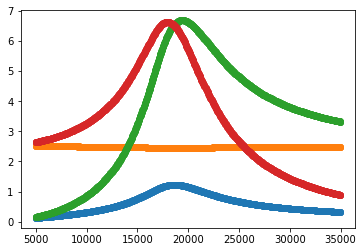

In [15]:

plt.scatter(frequencies,amplitudeR)
plt.scatter(frequencies,amplitudeGen)
plt.scatter(frequencies,amplitudeL)
plt.scatter(frequencies,amplitudeC)

We now define the function we are going to fit the data with: $$ V_R = \frac{R_rV_0}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$
$$ V_L = \frac{\omega L V_0}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$
$$ V_C = \frac{\frac{V_0}{\omega C}}{\sqrt{R^2+{ \left(\omega L - \frac{1}{\omega C}\right)}^2}}$$

 $\omega = 2 \pi f$ with $f$ being the sinusoidal generator frequency. We've chosen to estimate the uncertainty associated to the amplitude measures with the sample standard deviation $\sigma$ since how the DAQ program outputs the amplitude values is not known.


In [16]:
def R_amp_model(f, R_r , R, L, C, V_0):
    num = R_r * V_0
    den = np.sqrt( R**2 + (2*np.pi*f * L - 1/(2*np.pi*f * C))**2)
    return num / den
def L_amp_model(f, R, L, C, V_0):
    num = 2*np.pi*f * L * V_0
    den = np.sqrt( R**2 + (2*np.pi*f * L - 1/(2*np.pi*f * C))**2)
    return num / den
def C_amp_model(f, R, L, C, V_0):
    num = V_0 / (2*np.pi*f * C)
    den = np.sqrt( R**2 + (2*np.pi*f * L - 1/(2*np.pi*f * C))**2)
    return num / den

We now have to make our initial guess of the fitting parameters. We can make exact initial guesses or set bounds for params values

In [17]:
#initial guesses(theoretical values)
R_r = 996.7
R = 1.17252e+03
L = 4.741e-02
C = 1.46e-09
V_0 = 1.0

initial_guess_R = np.array([R_r , R, L, C, V_0])
initial_guess_L = np.array([R, L, C, V_0])
initial_guess_C = np.array([R, L, C, V_0])

boundsR = [[990,990,3.5e-02,1.3e-09,0.0],[1050,2000,5e-02,1.6e-09,3.0]]
boundsL = [[990,3.5e-02,1.3e-09,0.0],[3000,5e-02,1.6e-09,3.0]]
boundsC = [[990,3.5e-02,1.3e-09,0.0],[3000,5e-02,1.6e-09,3.0]]


We now get the data
We now compute $\sigma$

In [18]:
from statistics import stdev

file_folder = 'data/actual data/Constant frequency/'
file_name = 'freq18kHz.csv'
data_file = file_folder + file_name

freqAmpGen  = np.loadtxt(data_file, delimiter = ',', skiprows = 1, usecols = (1), unpack = True)

amplitude_stdev = stdev(freqAmpGen)
ampError = []
for x in range(len(frequencies)):
    ampError.append(amplitude_stdev)

ampError

[0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763685597,
 0.0004882542763

### Curve fit routine
We are now going to use curve_fit function from scipy

In [19]:
# load curve_fit routine from scipy
from scipy.optimize import curve_fit # import method used here

# the method returns two arrays: one with the resulting fit parameters and then the covariance matrix
fit_R, covariance_R = curve_fit(R_amp_model, frequencies, amplitudeR,bounds=boundsR,sigma=ampError,absolute_sigma=True)
fit_L, covariance_L = curve_fit(L_amp_model, frequencies, amplitudeL,bounds=boundsL,sigma=ampError,absolute_sigma=True)
fit_C, covariance_C = curve_fit(C_amp_model, frequencies, amplitudeC,bounds=boundsC,sigma=ampError,absolute_sigma=True)

#the elements on the the diagonal represent the errors on the fit parameters
error_R = np.sqrt(np.diag(covariance_R))
error_L = np.sqrt(np.diag(covariance_L))
error_C = np.sqrt(np.diag(covariance_C))

Now printing out the first fit results

In [20]:
print()
print('R_r    = ','{:.3f}'.format(fit_R[0]), '±', '{:.5f}'.format(error_R[0]), ' $\Omega$')
print('R    = ','{:.3f}'.format(fit_R[1]), '±', '{:.6f}'.format(error_R[1]), ' $\Omega$')
print('L    = ','{:.5f}'.format(fit_R[2]), '±', '{:.3f}'.format(error_R[2]), ' Henry')
print('C    = ','{:.12f}'.format(fit_R[3]), '±', '{:.12f}'.format(error_R[3]), ' F')
print('V_0    = ','{:.3f}'.format(fit_R[4]), '±', '{:.3f}'.format(error_R[4]), ' V')

print()
print('R    = ','{:.3f}'.format(fit_L[0]), '±', '{:.3f}'.format(error_L[0]), ' $\Omega$')
print('L    = ','{:.5f}'.format(fit_L[1]), '±', '{:.3f}'.format(error_L[1]), ' Henry')
print('C    = ','{:.12f}'.format(fit_L[2]), '±', '{:.12f}'.format(error_L[2]), ' F')
print('V_0    = ','{:.3f}'.format(fit_L[3]), '±', '{:.3f}'.format(error_L[3]), ' V')

print()
print('R    = ','{:.3f}'.format(fit_C[0]), '±', '{:.3f}'.format(error_C[0]), ' $\Omega$')
print('L    = ','{:.5f}'.format(fit_C[1]), '±', '{:.3f}'.format(error_C[1]), ' Henry')
print('C    = ','{:.12f}'.format(fit_C[2]), '±', '{:.12f}'.format(error_C[2]), ' F')
print('V_0    = ','{:.3f}'.format(fit_C[3]), '±', '{:.3f}'.format(error_C[3]), ' V')


R_r    =  1037.485 ± 0.00000  $\Omega$
R    =  1998.175 ± 0.000000  $\Omega$
L    =  0.04688 ± 0.000  Henry
C    =  0.000000001523 ± 0.000000000000  F
V_0    =  2.376 ± 0.000  V

R    =  2111.122 ± 0.000  $\Omega$
L    =  0.04826 ± 0.000  Henry
C    =  0.000000001474 ± 0.000000000000  F
V_0    =  2.447 ± 0.000  V

R    =  2122.945 ± 0.000  $\Omega$
L    =  0.04853 ± 0.000  Henry
C    =  0.000000001486 ± 0.000000000000  F
V_0    =  2.420 ± 0.000  V


We now iterate the process to find new fitting parameters until the values(amplitudes) become stable

We now try to visualize the covariance matrix with a colorplot:

R


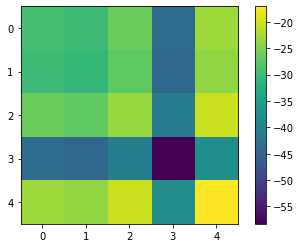

L


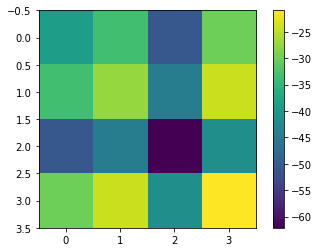

C


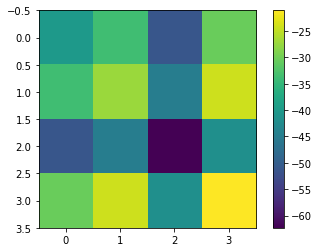

In [21]:
print('R')
plt.imshow(np.log(np.abs(covariance_R)))
plt.colorbar()
plt.show()
print('L')

plt.imshow(np.log(np.abs(covariance_L)))
plt.colorbar()
plt.show()
print('C')

plt.imshow(np.log(np.abs(covariance_C)))
plt.colorbar()
plt.show()

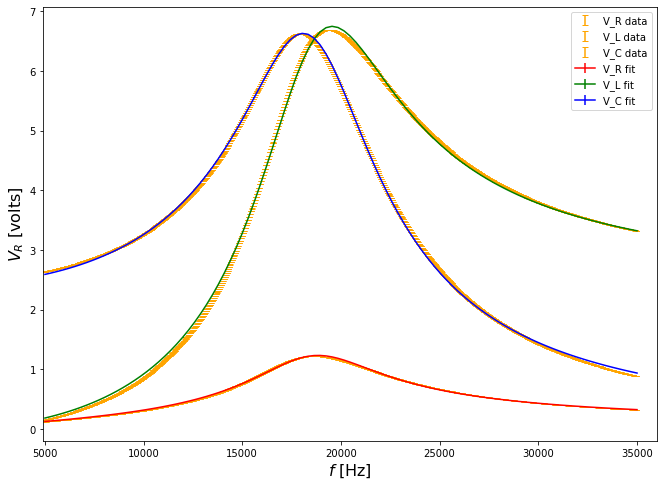

In [22]:
%matplotlib inline

plt.figure(figsize = (11,8))                  #specify figure size as 7 x 5 inches
#for default size, type plt.figure()

plt.xlabel(r"$f$ [Hz]", fontsize = 16) #label axis (using LaTeX commands)
plt.ylabel(r"$V_R$ [volts]", fontsize = 16)   #use 18 point font for label text

# Plotting the actual experimental data
plt.errorbar(frequencies, amplitudeR,
             xerr=None, yerr=amplitude_stdev,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "V_R data")
plt.errorbar(frequencies, amplitudeL,
             xerr=None, yerr=amplitude_stdev,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "V_L data")
plt.errorbar(frequencies, amplitudeC,
             xerr=None, yerr=amplitude_stdev,
             linestyle = 'none',
             color = 'orange',
             capsize = 3, capthick = 1, label = "V_C data")

#create curve showing fit to data
freq_fit = np.linspace(5000, 35000, 100)
VR_fit = R_amp_model(freq_fit, fit_R[0], fit_R[1], fit_R[2],fit_R[3],fit_R[4])
VL_fit = L_amp_model(freq_fit, fit_L[0], fit_L[1], fit_L[2],fit_L[3])
VC_fit = C_amp_model(freq_fit, fit_C[0], fit_C[1], fit_C[2],fit_C[3])

#plotting the fitting curves
plt.errorbar(freq_fit, VR_fit, xerr = None, yerr = amplitude_stdev, color = 'red', label = 'V_R fit' )
plt.errorbar(freq_fit, VL_fit, xerr = None, yerr = amplitude_stdev, color = 'green', label = 'V_L fit' )
plt.errorbar(freq_fit, VC_fit, xerr = None, yerr = amplitude_stdev, color = 'blue', label = 'V_C fit' )
plt.xlim(4900 , 36000)
# plt.ylim(0.0,7.0)
# plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360],
#            ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')

plt.savefig('figs/Amplitudes-scipy.pdf')


## Fit accuracy

Calculating the residuals

In [23]:
V_R_model = R_amp_model(frequencies, fit_R[0], fit_R[1], fit_R[2], fit_R[3],fit_R[4])
residual_R = amplitudeR - V_R_model
V_L_model = L_amp_model(frequencies, fit_L[0], fit_L[1], fit_L[2], fit_L[3])
residual_L = amplitudeL - V_L_model
V_C_model = C_amp_model(frequencies, fit_C[0], fit_C[1], fit_C[2], fit_C[3])
residual_C = amplitudeC - V_C_model

residual_L

array([-3.07128736e-02, -3.07110665e-02, -3.06592835e-02, -3.06584878e-02,
       -3.06584730e-02, -3.07150706e-02, -3.07187429e-02, -3.08183868e-02,
       -3.09838653e-02, -3.09833632e-02, -3.11862030e-02, -3.11851018e-02,
       -3.14570489e-02, -3.17696254e-02, -3.17697123e-02, -3.21257757e-02,
       -3.21255121e-02, -3.25560817e-02, -3.20263343e-02, -3.20206608e-02,
       -3.25667072e-02, -3.25656134e-02, -3.31435221e-02, -3.27890410e-02,
       -3.27950164e-02, -3.34848313e-02, -3.34837919e-02, -3.32470227e-02,
       -3.30454816e-02, -3.30452881e-02, -3.39063817e-02, -3.39082419e-02,
       -3.38409952e-02, -3.38131945e-02, -3.38133949e-02, -3.38625982e-02,
       -3.49579459e-02, -3.49578433e-02, -3.51240889e-02, -3.51236737e-02,
       -3.53410411e-02, -3.56097436e-02, -3.56111245e-02, -3.59676025e-02,
       -3.59642712e-02, -3.63612411e-02, -3.68360459e-02, -3.58394545e-02,
       -3.63583089e-02, -3.63566407e-02, -3.69664257e-02, -3.66124778e-02,
       -3.76145259e-02, -

In [24]:
chisq_R = sum((residual_R/ ampError)**2)
degrees_of_freedom_R = len(residual_R) - len(initial_guess_R)


chisq_R
# reduced_chisq_R = chisq_R / degrees_of_freedom_R  # this should be close to one
# CDF_R = chi2.cdf(chisq_R, degrees_of_freedom_R)   # this should be close to 50 percent
#
# chisq_L = sum((residual_L/ data_uncertainty)**2) #typo corrected
# degrees_of_freedom_L = len(residual_L) - len(initial_guess_L)
# reduced_chisq_L = chisq_L / degrees_of_freedom_L  # this should be close to one
# CDF_L = chi2.cdf(chisq_L, degrees_of_freedom_L)   # this should be close to 50 percent
#
# chisq_C = sum((residual_C/ data_uncertainty)**2) #typo corrected
# degrees_of_freedom_C = len(residual_C) - len(initial_guess_C)
# reduced_chisq_C = chisq_C / degrees_of_freedom_C  # this should be close to one
# CDF_C = chi2.cdf(chisq_C, degrees_of_freedom_C)   # this should be close to 50 percent
#
# print('chi-square         = ',chisq_R)
# print('degrees of freedom = ',degrees_of_freedom_R)
# print('reduced chi-square = ',reduced_chisq_R)
# print('fractional probability of chisq ≤', chisq_R, 'for ', degrees_of_freedom_R, 'dof is', CDF_R)
#
# print('chi-square         = ',chisq_L)
# print('degrees of freedom = ',degrees_of_freedom_L)
# print('reduced chi-square = ',reduced_chisq_L)
# print('fractional probability of chisq ≤', chisq_L, 'for ', degrees_of_freedom_L, 'dof is', CDF_L)
#
# print('chi-square         = ',chisq_C)
# print('degrees of freedom = ',degrees_of_freedom_C)
# print('reduced chi-square = ',reduced_chisq_C)
# print('fractional probability of chisq ≤', chisq_C, 'for ', degrees_of_freedom_C, 'dof is', CDF_C)

286128.09744116146